In [1]:
import sys
sys.path.append('../')

import numpy as np
import networkx as nx
import itertools
import torch
import torch.nn.functional as F
import torch_sparse
import random 
import matplotlib.pyplot as plt
import seaborn as sns

from torch import nn
from models.sheaf_base import SheafDiffusion
from models.cont_models import GraphLaplacianDiffusion, DiagSheafDiffusion
from lib.laplace import get_1d_oracle_maps
from torch_geometric.nn.dense.linear import Linear
from scipy import linalg
from data.heterophilic import generate_random_splits
from torch_geometric.utils import to_dense_adj, from_networkx
from torch_geometric.nn.conv import GCNConv
from models import laplacian_builders as lb
from torchdiffeq import odeint
from torchdiffeq import odeint_adjoint

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float32)

import matplotlib as mpl
sns.set(font_scale=1.3)  

%load_ext autoreload
%autoreload 2

#### Create bipartite dataset

In [1]:
def create_binary_graph_dataset(num_nodes=100, max_edges_per_V_node=10, input_features=5, inter_p=1.0):
    assert 0 <= inter_p <= 1.0
    while True:
        # We randomly generate graphs until we produce a connected one
        graph = nx.Graph()

        # Partition the graph into two sets. 
        V_nodes = list(range(num_nodes // 2))
        U_nodes = list(range(num_nodes // 2, num_nodes))
        graph.add_nodes_from(V_nodes + U_nodes)

        # Randomly generate edges between nodes
        edges = []
        for v_node in V_nodes:
            edges_per_node = random.randint(1, max_edges_per_V_node)
            for _ in range(edges_per_node):
                sample = np.random.uniform(0, 1)
                if sample <= inter_p:
                    u_node = random.choice(U_nodes)
                else:
                    u_node = random.choice(V_nodes)
                if u_node != v_node:
                    edges.append((v_node, u_node))
        graph.add_edges_from(edges)
        if nx.is_connected(graph):
            break
            
    if inter_p == 1.0:
        assert nx.algorithms.is_bipartite(graph)
        
    # Convert the graph to a PyTorch geometric data object
    data = from_networkx(graph)

    # Add dummy features to the graph
    x_V = torch.empty((len(V_nodes), input_features)).normal_(mean=-0.1,std=0.5)
    x_U = torch.empty((len(U_nodes), input_features)).normal_(mean=0.1,std=0.5)
    x = torch.cat((x_V, x_U), dim=0)
    data.x = x

    # Add labels
    y = torch.arange(num_nodes)
    mask = y < (num_nodes // 2)
    y[mask] = 1
    y[~mask] = 0
    data.y = y
    assert torch.sum(y) == num_nodes // 2
    
    # Meta
    data.num_nodes = num_nodes
    data.in_features = input_features
    
    return data

In [8]:
inter_p=1.0
data = create_binary_graph_dataset(inter_p=inter_p)
data = generate_random_splits(data, num_classes=2, val_rate=0.0)

#### Train Laplacian difussion models

In [9]:
times = torch.arange(0, 11, step=1.0)
seeds = 5

args = {
    'hidden_channels': 10,
    'layers': -1,
    'device': torch.device('cpu'),
    'normalised': True,
    'deg_normalised': False,
    'linear': True,
    'input_dropout': 0.0,
    'dropout': 0.0,
    'left_weights': False,
    'right_weights': False,
    'use_act': False,
    'second_linear': False,
    'add_lp': False,
    'add_hp': False,
    'sheaf_act': 'tanh',
    'tol_scale': 1.0,
    'int_method': 'dopri5',
    'step_size': None,
    'max_iters': None,
    'tol_scale_adjoint': 1.0,
    'adjoint_method': 'euler',
    'adjoint_step_size': None,
    'edge_weights': False,
    'orth': 'householder',
    'd': 1,
    'adjoint': False,
    'graph_size': data.num_nodes,
    'input_dim': 5,
    'output_dim': 2,
}

In [10]:
def eval_model(model, data, mask):
    model.eval()
    pred = model(data.x).argmax(dim=1)
    correct = (pred[mask] == data.y[mask]).sum()
    acc = int(correct) / int(mask.sum())
    return acc

In [11]:
train_res, test_res = [], []
for seed in range(seeds):
    diff_train_acc, diff_test_acc = [], []
    for t in times:
        args['max_t'] = t
        args['graph_size'] = data.num_nodes
        args['input_dim'] = 5
        args['output_dim'] = 2

        model = GraphLaplacianDiffusion(data.edge_index, args)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)

        model.train()
        for epoch in range(201):
            optimizer.zero_grad()
            out = model(data.x)
            loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if epoch % 100 == 0 and epoch > 0:
                print(f"Epoch: {epoch} | Loss: {loss.item()}")

        train_acc = eval_model(model, data, data.train_mask)
        test_acc = eval_model(model, data, data.test_mask)
        print(f'Time: {t.item()}')
        print('Train Accuracy: {:.4f}'.format(train_acc))
        print('Test Accuracy: {:.4f}'.format(test_acc))

        diff_train_acc.append(train_acc)
        diff_test_acc.append(test_acc)
    train_res.append(diff_train_acc)
    test_res.append(diff_test_acc)

Epoch: 100 | Loss: 0.6038112640380859
Epoch: 200 | Loss: 0.6038083434104919
Time: 0.0
Train Accuracy: 0.6333
Test Accuracy: 0.5000
Epoch: 100 | Loss: 0.4512142837047577
Epoch: 200 | Loss: 0.43409931659698486
Time: 1.0
Train Accuracy: 0.7500
Test Accuracy: 0.4000
Epoch: 100 | Loss: 0.4070935845375061
Epoch: 200 | Loss: 0.3502946197986603
Time: 2.0
Train Accuracy: 0.8167
Test Accuracy: 0.3750
Epoch: 100 | Loss: 0.3803170621395111
Epoch: 200 | Loss: 0.3233568072319031
Time: 3.0
Train Accuracy: 0.8333
Test Accuracy: 0.3500
Epoch: 100 | Loss: 0.37356606125831604
Epoch: 200 | Loss: 0.30127397179603577
Time: 4.0
Train Accuracy: 0.8500
Test Accuracy: 0.3750
Epoch: 100 | Loss: 0.3933703303337097
Epoch: 200 | Loss: 0.30746185779571533
Time: 5.0
Train Accuracy: 0.8667
Test Accuracy: 0.3750
Epoch: 100 | Loss: 0.3694382309913635
Epoch: 200 | Loss: 0.2888871431350708
Time: 6.0
Train Accuracy: 0.8667
Test Accuracy: 0.3750
Epoch: 100 | Loss: 0.3760877847671509
Epoch: 200 | Loss: 0.310087114572525
Time

#### Train Sheaf Difussion Model

In [12]:
sheaf_train_res, sheaf_test_res = [], []
for seed in range(seeds):
    sheaf_train_acc, sheaf_test_acc = [], []
    for t in times:
        args['max_t'] = t
        model = DiagSheafDiffusion(data.edge_index, args) 
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)

        model.train()
        for epoch in range(201):
            optimizer.zero_grad()
            out = model(data.x)
            loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if epoch % 100 == 0 and epoch > 0:
                print(f"Epoch: {epoch} | Loss: {loss.item()}")

        train_acc = eval_model(model, data, data.train_mask)
        test_acc = eval_model(model, data, data.test_mask)
        print('Train Accuracy: {:.4f}'.format(train_acc))
        print('Test Accuracy: {:.4f}'.format(test_acc))

        sheaf_train_acc.append(train_acc)
        sheaf_test_acc.append(test_acc)
    sheaf_train_res.append(sheaf_train_acc)
    sheaf_test_res.append(sheaf_test_acc)

Epoch: 100 | Loss: 0.6038208603858948
Epoch: 200 | Loss: 0.6038080453872681
Train Accuracy: 0.6333
Test Accuracy: 0.5000
Epoch: 100 | Loss: 0.5111703872680664
Epoch: 200 | Loss: 0.45245108008384705
Train Accuracy: 0.8167
Test Accuracy: 0.5000
Epoch: 100 | Loss: 0.33931225538253784
Epoch: 200 | Loss: 0.30442458391189575
Train Accuracy: 0.9167
Test Accuracy: 0.5500
Epoch: 100 | Loss: 0.26346659660339355
Epoch: 200 | Loss: 0.23618729412555695
Train Accuracy: 0.9500
Test Accuracy: 0.7750
Epoch: 100 | Loss: 0.3496437668800354
Epoch: 200 | Loss: 0.16329455375671387
Train Accuracy: 0.9500
Test Accuracy: 0.6500
Epoch: 100 | Loss: 0.11256158351898193
Epoch: 200 | Loss: 0.05319179967045784
Train Accuracy: 0.9667
Test Accuracy: 0.9750
Epoch: 100 | Loss: 0.4694617688655853
Epoch: 200 | Loss: 0.4101913273334503
Train Accuracy: 0.8333
Test Accuracy: 0.4500
Epoch: 100 | Loss: 0.0752425566315651
Epoch: 200 | Loss: 0.024546701461076736
Train Accuracy: 1.0000
Test Accuracy: 1.0000
Epoch: 100 | Loss: 0.2

#### Build and Train Oracle Sheaf

In [13]:
class StandardODEFunc(nn.Module):
    """Implements Laplacian-based diffusion."""

    def __init__(self, d, L):
        super(StandardODEFunc, self).__init__()
        self.d = d
        self.L = L
        
    def forward(self, t, x):
        return torch_sparse.spmm(self.L[0], self.L[1], x.size(0), x.size(0), -x)
    
class ODEBlock(nn.Module):
    """Module performing the ODE Integration."""

    def __init__(self, odefunc, t, opt):
        super(ODEBlock, self).__init__()
        self.t = t
        self.opt = opt
        self.odefunc = odefunc
        self.set_tol()

    def set_tol(self):
        self.atol = self.opt['tol_scale'] * 1e-7
        self.rtol = self.opt['tol_scale'] * 1e-9
        if self.opt['adjoint']:
            self.atol_adjoint = self.opt['tol_scale_adjoint'] * 1e-7
            self.rtol_adjoint = self.opt['tol_scale_adjoint'] * 1e-9

    def reset_tol(self):
        self.atol = 1e-7
        self.rtol = 1e-9
        self.atol_adjoint = 1e-7
        self.rtol_adjoint = 1e-9

    def forward(self, x):
        if self.opt["adjoint"] and self.training:
            z = odeint_adjoint(
                self.odefunc, x, self.t,
                method=self.opt['int_method'],
                options=dict(step_size=self.opt['step_size'], max_iters=self.opt['max_iters']),
                adjoint_method=self.opt['adjoint_method'],
                adjoint_options=dict(step_size=self.opt['adjoint_step_size'], max_iters=self.opt['max_iters']),
                atol=self.atol,
                rtol=self.rtol,
                adjoint_atol=self.atol_adjoint,
                adjoint_rtol=self.rtol_adjoint)
        else:
            z = odeint(
                self.odefunc, x, self.t,
                method=self.opt['int_method'],
                options=dict(step_size=self.opt['step_size'], max_iters=self.opt['max_iters']),
                atol=self.atol,
                rtol=self.rtol)
        return z[1]

In [14]:
class OneDimOracleSheafDiffusion(SheafDiffusion):
    """Performs diffusion using a sheaf Laplacian with diagonal restriction maps."""

    def __init__(self, edge_index, labels, args):
        super(OneDimOracleSheafDiffusion, self).__init__(edge_index, args)
        self.labels = labels
        
        self.lin1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.lin2 = nn.Linear(self.hidden_dim, self.output_dim)
        
        maps = get_1d_oracle_maps(edge_index, labels)
        laplacian_builder = lb.DiagLaplacianBuilder(
            self.graph_size, edge_index, d=self.d)
        self.L, _ = laplacian_builder(maps)

        self.odefunc = StandardODEFunc(self.d, self.L)
        self.odeblock = ODEBlock(self.odefunc, self.time_range, args)
                

    def forward(self, x):
        x = self.lin1(x)
        if self.t > 0:
            x = x.view(self.graph_size * self.final_d, -1)
            x = self.odeblock(x)
        
        x = x.view(self.graph_size, -1)
        x = self.lin2(x)
        return F.log_softmax(x, dim=1)

In [15]:
oracle_train_res, oracle_test_res = [], []
for seed in range(seeds):
    oracle_train_acc, oracle_test_acc = [], []
    for t in times:
        args['max_t'] = t

        model = OneDimOracleSheafDiffusion(data.edge_index, data.y, args) 
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)

        model.train()
        for epoch in range(201):
            optimizer.zero_grad()
            out = model(data.x)
            loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if epoch % 100 == 0 and epoch > 0:
                print(f"Epoch: {epoch} | Loss: {loss.item()}")

        train_acc = eval_model(model, data, data.train_mask)
        test_acc = eval_model(model, data, data.test_mask)
        print('Train Accuracy: {:.4f}'.format(train_acc))
        print('Test Accuracy: {:.4f}'.format(test_acc))

        oracle_train_acc.append(train_acc)
        oracle_test_acc.append(test_acc)
    oracle_train_res.append(oracle_train_acc)
    oracle_test_res.append(oracle_test_acc)

Epoch: 100 | Loss: 0.6038109064102173
Epoch: 200 | Loss: 0.6038082838058472
Train Accuracy: 0.6333
Test Accuracy: 0.5000
Epoch: 100 | Loss: 0.10638335347175598
Epoch: 200 | Loss: 0.06873335689306259
Train Accuracy: 0.9667
Test Accuracy: 0.9000
Epoch: 100 | Loss: 0.02382555417716503
Epoch: 200 | Loss: 0.008886830881237984
Train Accuracy: 1.0000
Test Accuracy: 1.0000
Epoch: 100 | Loss: 0.025068553164601326
Epoch: 200 | Loss: 0.008051467128098011
Train Accuracy: 1.0000
Test Accuracy: 1.0000
Epoch: 100 | Loss: 0.01841830648481846
Epoch: 200 | Loss: 0.006941482424736023
Train Accuracy: 1.0000
Test Accuracy: 1.0000
Epoch: 100 | Loss: 0.0180361345410347
Epoch: 200 | Loss: 0.006941671017557383
Train Accuracy: 1.0000
Test Accuracy: 1.0000
Epoch: 100 | Loss: 0.017254889011383057
Epoch: 200 | Loss: 0.006936430465430021
Train Accuracy: 1.0000
Test Accuracy: 1.0000
Epoch: 100 | Loss: 0.019534187391400337
Epoch: 200 | Loss: 0.007124532479792833
Train Accuracy: 1.0000
Test Accuracy: 1.0000
Epoch: 100

#### Plotting

In [16]:
def agg_results(res):
    res = np.array(res)
    mean = np.mean(res, axis=0)
    std = np.std(res, axis=0) 
    return mean, std

In [17]:
# Performance as a function of the difussion time
graph_mean_train, graph_std_train = agg_results(train_res)
graph_mean_test, graph_std_test = agg_results(test_res) 

sheaf_mean_train, sheaf_std_train = agg_results(sheaf_train_res)
sheaf_mean_test, sheaf_std_test = agg_results(sheaf_test_res)

oracle_mean_train, oracle_std_train = agg_results(oracle_train_res)
oracle_mean_test, oracle_std_test = agg_results(oracle_test_res)

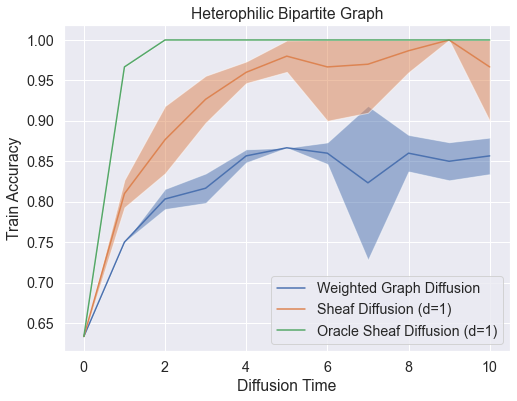

In [32]:
plt.figure(figsize=(8, 6))

plt.plot(times, graph_mean_train, label="Weighted Graph Diffusion")
plt.fill_between(times, graph_mean_train - graph_std_train, np.clip(graph_mean_train + graph_std_train, 0.0, 1.0), alpha=0.5)

plt.plot(times, sheaf_mean_train, label="Sheaf Diffusion (d=1)")
plt.fill_between(times, sheaf_mean_train - sheaf_std_train, np.clip(sheaf_mean_train + sheaf_std_train, 0.0, 1.0), alpha=0.5)

plt.plot(times, oracle_mean_train, label="Oracle Sheaf Diffusion (d=1)")
plt.fill_between(times, oracle_mean_train - oracle_std_train, np.clip(oracle_mean_train + oracle_std_train, 0.0, 1.0), alpha=0.5)

plt.legend()
plt.title(fr"Heterophilic Bipartite Graph")
plt.xlabel('Diffusion Time')
plt.ylabel('Train Accuracy')
plt.savefig("biartite.pdf", bbox_inches='tight')
plt.show()

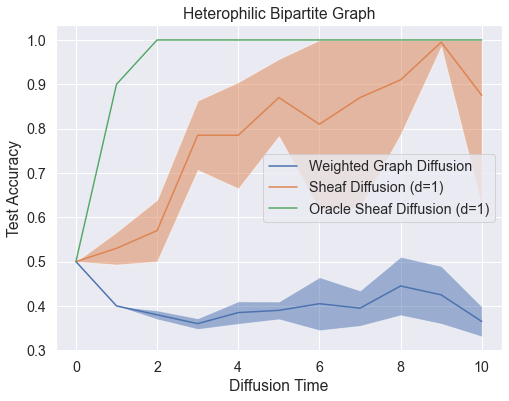

In [33]:
plt.figure(figsize=(8, 6))

plt.plot(times, graph_mean_test, label="Weighted Graph Diffusion")
plt.fill_between(times, graph_mean_test - graph_std_test, np.clip(graph_mean_test + graph_std_test, 0.0, 1.0), alpha=0.5)

plt.plot(times, sheaf_mean_test, label="Sheaf Diffusion (d=1)")
plt.fill_between(times, sheaf_mean_test - sheaf_std_test, np.clip(sheaf_mean_test + sheaf_std_test, 0.0, 1.0), alpha=0.5)

plt.plot(times, oracle_mean_test, label="Oracle Sheaf Diffusion (d=1)")
plt.fill_between(times, oracle_mean_test - oracle_std_test, oracle_mean_test + oracle_std_test, alpha=0.5)

plt.legend()
plt.title(fr"Heterophilic Bipartite Graph")
plt.xlabel('Diffusion Time')
plt.ylabel('Test Accuracy')
plt.savefig("biartite_test.pdf", bbox_inches='tight')
plt.show()

#### Examining the learned Laplacian

In [30]:
# Define the model
args['max_t'] = 9.0
model = DiagSheafDiffusion(data.edge_index, args) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)

# Check how the entries of the Laplacian look like in the beginning
maps = model.sheaf_learner(model.lin1(data.x), data.edge_index)
_, non_diag_vals_before = model.laplacian_builder(maps)

model.train()
for epoch in range(201):
    optimizer.zero_grad()
    out = model(data.x)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0 and epoch > 0:
        print(f"Epoch: {epoch} | Loss: {loss.item()}")

train_acc = eval_model(model, data, data.train_mask)
test_acc = eval_model(model, data, data.test_mask)
print('Train Accuracy: {:.4f}'.format(train_acc))
print('Test Accuracy: {:.4f}'.format(test_acc))

# Check how the entries of the Laplacian look like in the beginning
maps = model.sheaf_learner(model.lin1(data.x), data.edge_index)
_, non_diag_vals_after = model.laplacian_builder(maps)

Epoch: 100 | Loss: 0.060776617377996445
Epoch: 200 | Loss: 0.015331415459513664
Train Accuracy: 1.0000
Test Accuracy: 1.0000


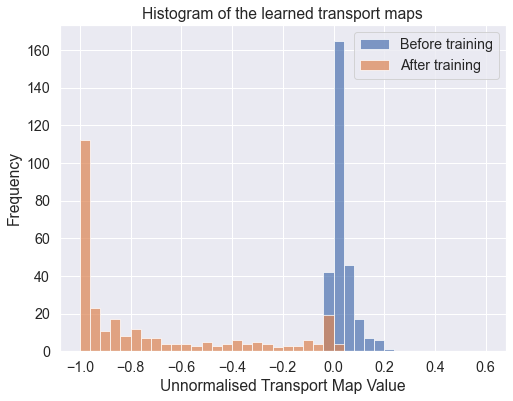

In [34]:
# The structure of the learned Laplacian 
plt.figure(figsize=(8, 6))
plt.hist(-non_diag_vals_before.detach().numpy(), bins=40, range=(-1, 0.6), alpha=0.7, label='Before training')
plt.hist(-non_diag_vals_after.detach().numpy(), bins=40, range=(-1, 0.6), alpha=0.7, label='After training')
plt.legend()
plt.title(fr"Histogram of the learned transport maps")
plt.xlabel('Unnormalised Transport Map Value')
plt.ylabel('Frequency')
plt.savefig("transport_hist.pdf", bbox_inches='tight')
plt.show()

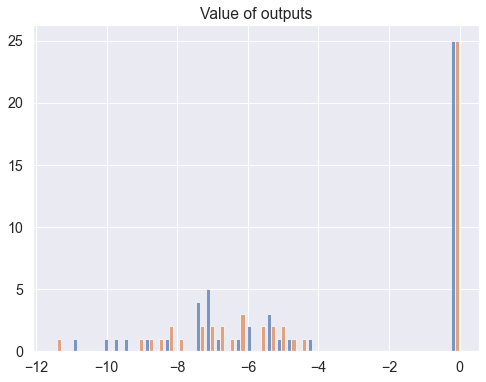

In [39]:
# The outputs
plt.figure(figsize=(8, 6))
plt.hist(out.detach().numpy(), bins=40, alpha=0.7)
# plt.legend()
plt.title(fr"Value of outputs")
plt.show()

### Graph Laplacian Histogram

In [40]:
# Define the model
args['max_t'] = 20.0
args['graph_size'] = train.num_nodes
args['input_dim'] = 5
args['output_dim'] = 2
model = GraphLaplacianDiffusion(train.edge_index, args) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

# Check how the entries of the Laplacian look like in the beginning
maps = model.sheaf_learner(model.lin1(train.x), train.edge_index)
_, non_diag_vals_before = model.laplacian_builder(maps)

model.train()
for epoch in range(201):
    optimizer.zero_grad()
    out = model(train.x)
    loss = F.nll_loss(out, train.y)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0 and epoch > 0:
        print(f"Epoch: {epoch} | Loss: {loss.item()}")

train_acc = eval_model(model, train)
test_acc = eval_model(model, test)
print('Train Accuracy: {:.4f}'.format(train_acc))
print('Test Accuracy: {:.4f}'.format(test_acc))

# Check how the entries of the Laplacian look like in the beginning
maps = model.sheaf_learner(model.lin1(train.x), train.edge_index)
_, non_diag_vals_after = model.laplacian_builder(maps)

Epoch: 100 | Loss: 0.4838200509548187
Epoch: 200 | Loss: 0.46566474437713623
Train Accuracy: 0.7400
Test Accuracy: 0.5200


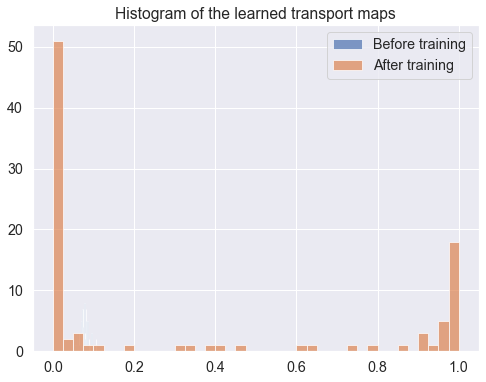

In [41]:
# The structure of the learned Laplacian 
plt.figure(figsize=(8, 6))
plt.hist(-non_diag_vals_after.detach().numpy(), bins=40, alpha=0.7, label='After training')
plt.legend()
plt.title(fr"Histogram of the learned transport maps")
plt.show()